In [2]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from gensim. corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Phrases
import re
from datetime import datetime

In [3]:
#reads average US student cost csv, average International Tuition Cost csv, and german masters cost csv and cleans then

costPerStateDf = pd.read_csv("averageCostStudentPerUsState.csv")
costPerStateDf = costPerStateDf.loc[costPerStateDf['Expense'] == 'Fees/Tuition'][['Year', 'State', 'Length', 'Value']]

costPerCountryDf = pd.read_csv("averageTuitionPerCountry.csv")
costPerCountryDf = costPerCountryDf[['Country', 'Average Tuition (International)']]

germanMastersDf = pd.read_csv("germanGraduateProgramCost.csv")
germanMastersDf = germanMastersDf[['City Name', 'Duration', 'Tuition Fee']]
germanMastersFreeDf = germanMastersDf.loc[germanMastersDf['Tuition Fee'] == 'none'].reset_index(drop=True)
germanMastersPaidDf = germanMastersDf.loc[germanMastersDf['Tuition Fee'] != 'none'].reset_index(drop=True)

Mean tuition of US Colleges: 17857.33846153846  And std tuition of US Colleges: 12857.673147636444  And min tuition of US Colleges: 1285  And max tuition of US Colleges: 49152
Mean tuition of US Colleges: 16313.888888888889  And std tuition of US Colleges: 10232.194801581738  And min tuition of US Colleges: 2925  And max tuition of US Colleges: 32500


Text(0.5, 1.0, '2 Year Schools that have Free Tuition vs. Paid Tuition in US')

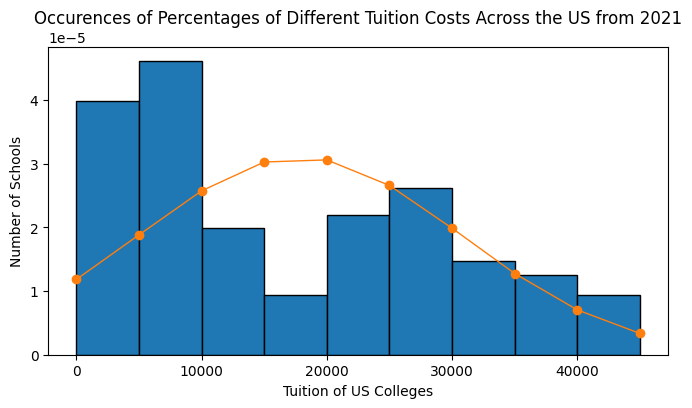

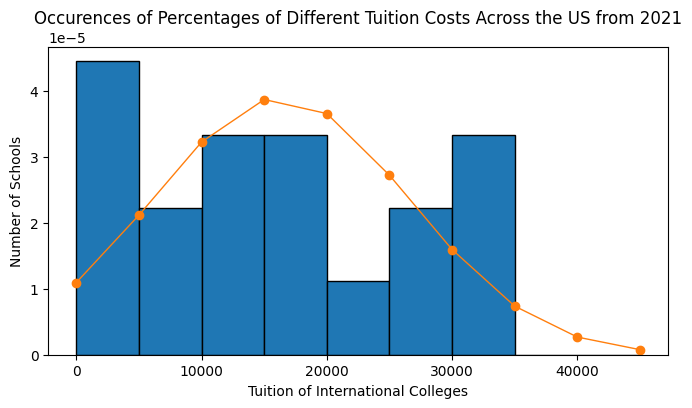

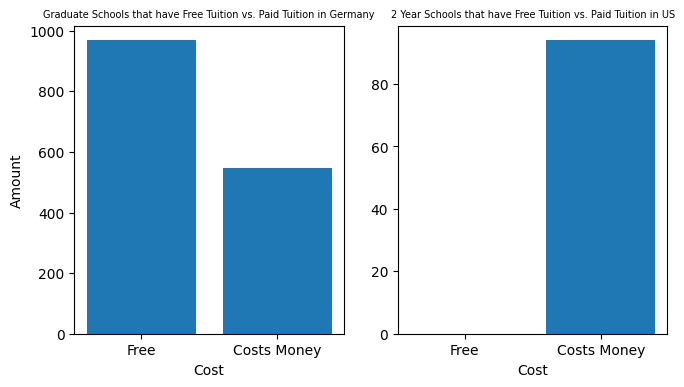

In [11]:
#creates graphs to show how colleges in the United States and for US students are more expensive 

#determines the size of the bins for the histogram to be from 0 to .8 in intervals of .05
size_bins = np.arange(0,50000,5000)


#US College Tuition Stats and Visualization
#mean and std
meanCostPerState = costPerStateDf.loc[costPerStateDf['Year'] == 2021]['Value'].mean()
stdCostPerState = costPerStateDf.loc[costPerStateDf['Year'] == 2021]['Value'].std(ddof=1)
minCostPerState = costPerStateDf.loc[costPerStateDf['Year'] == 2021]['Value'].min()
maxCostPerState = costPerStateDf.loc[costPerStateDf['Year'] == 2021]['Value'].max()
print("Mean tuition of US Colleges:", meanCostPerState, " And std tuition of US Colleges:", stdCostPerState, " And min tuition of US Colleges:", minCostPerState, " And max tuition of US Colleges:", maxCostPerState)

# to create the line of normal distribution
ys = []
for b in size_bins:
    ys.append(norm.pdf(b, meanCostPerState, stdCostPerState))
xs = size_bins

#creates histogram and line of normal distributio
plt.figure(figsize=(8, 4))
plt.hist(costPerStateDf.loc[costPerStateDf['Year'] == 2021]['Value'], bins = size_bins, edgecolor='k', density=True)
plt.plot(xs, ys, linewidth=1, marker='o')
plt.xticks(size_bins[::2])
plt.xlabel('Tuition of US Colleges')
plt.ylabel('Number of Schools')
plt.title('Occurences of Percentages of Different Tuition Costs Across the US from 2021')


#International Tuition Stats and Visualization
#mean and std
meanCostPerCountry = costPerCountryDf['Average Tuition (International)'].mean()
stdCostPerCountry = costPerCountryDf['Average Tuition (International)'].std(ddof=1)
minCostPerCountry = costPerCountryDf['Average Tuition (International)'].min()
maxCostPerCountry = costPerCountryDf['Average Tuition (International)'].max()
print("Mean tuition of US Colleges:", meanCostPerCountry, " And std tuition of US Colleges:", stdCostPerCountry, " And min tuition of US Colleges:", minCostPerCountry, " And max tuition of US Colleges:", maxCostPerCountry)

# to create the line of normal distribution
ys = []
for b in size_bins:
    ys.append(norm.pdf(b, meanCostPerCountry, stdCostPerCountry))
xs = size_bins

#creates histogram and line of normal distributio
plt.figure(figsize=(8, 4))
plt.hist(costPerCountryDf['Average Tuition (International)'], bins = size_bins, edgecolor='k', density=True)
plt.plot(xs, ys, linewidth=1, marker='o')
plt.xticks(size_bins[::2])
plt.xlabel('Tuition of International Colleges')
plt.ylabel('Number of Schools')
plt.title('Occurences of Percentages of Different Tuition Costs Across the US from 2021')



#Plots how many Graduate Programs in Germany are free vs cost moey and how many 2 year programs in the US are free vs cost money
plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.bar(['Free', 'Costs Money'], [len(germanMastersFreeDf), len(germanMastersPaidDf)])
plt.xlabel('Cost')
plt.ylabel('Amount')
plt.title('Graduate Schools that have Free Tuition vs. Paid Tuition in Germany', fontsize=7)

plt.subplot(1,4,2)
plt.bar(['Free', 'Costs Money'], [len(costPerStateDf.loc[costPerStateDf['Value'] == 0]), len(costPerStateDf.loc[(costPerStateDf['Value'] != 0) & (costPerStateDf['Length'] == '2-year')])])
plt.xlabel('Cost')
plt.title('2 Year Schools that have Free Tuition vs. Paid Tuition in US', fontsize=7)

In [10]:
#Finds the cosine similarity to the phrase "Why so expensive." across all posts in college.csv and applyingtocollege.csv


#function that finds vector representation for each token
def get_vector(bow,dct):
    vector_len = len(dct.token2id)
    vector = np.zeros(vector_len)
    for tk in bow:
        vector[tk[0]] = tk[1]
    vector = vector/sum(vector)
    return vector

#finds the cosine similairty between two different sentences or phrases
def cosine_sim(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))


#reads the csv created from the posts webscraped from the college subreddit
df = pd.read_csv("college.csv")
df['timestamp'] = df['created_utc'].apply(lambda epoch:datetime.fromtimestamp(epoch)) #converts created utc to datetime format
df = df.sort_values(by='created_utc') #sorts dataframe based on earliest posts first
df=df.reset_index(drop=True)

#converts text to tokens, bow, and finds vector representation and cosine similarity
df['text'] = df['text'].apply(str.lower)
#remove @s, #s, urls, and rt
df['tokens'] = df['text'].apply(lambda txt: re.sub(r'@\w+|#\w+|http.+|rt\s', '', txt))
#tokenizes the words
df['tokens'] = df['tokens'].apply(word_tokenize)

#find phrases that have been used 30 or more times
phraser = Phrases(df['tokens'], min_count=30, delimiter='_')
df['tokens'] = df['tokens'].apply(lambda tokens:phraser[tokens])

#gets rid of stop words
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [t for t in tokens if t not in stop_words])

#keeps words tokenized if they are longer than 3 letters
df['tokens'] = df['tokens'].apply(lambda tokens: [t for t in tokens if len(t) > 3])

#stems the token words
stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda tokens: [stemmer.stem(tk) for tk in tokens])

#gensim dictionary and filters out words that appear less than twenty times
dct = Dictionary(df['tokens'])
dct.filter_extremes(no_below=20) 

#creates bow column from the dictionary and rows with three or more bow
df['bow'] = df['tokens'].apply(dct.doc2bow)
df = df.loc[df['bow'].apply(lambda bow: len(bow) >= 3)]

#creates vector representation for each index in the bag of words
df['vector'] = df['bow'].apply(lambda bow: get_vector(bow, dct))


#searches for cosine similarity
search = 'Why so expensive.'#sentence that will be searched throughout for cosine similarity
#turns the phrases into bow which is searched with previous dictionary to find vector
search = word_tokenize(search)
stop_words = set(stopwords.words('english'))
search = [s for s in search if s not in stop_words]
search = [s for s in search if len(s) >= 3]
search = [stemmer.stem(s) for s in search]
bow = dct.doc2bow(search)
vector = get_vector(bow, dct)

#finds vector representation for words that weren't filtered out in cdf dataframe
df['vector'] = df['bow'].apply(lambda bow: get_vector(bow, dct))

#iterates through cdf and finds cosine similarity with the phrase and text from posts still left
for index,row in df.iterrows():
    df.at[index, 'cossim'] = cosine_sim(row['vector'], vector)
#sorts based on highest cossim values and gets rid of one with 0
cdf_result = df.sort_values(by='cossim', ascending=False)
cdf_result = cdf_result.loc[cdf_result['cossim']>0]

cdf_result = cdf_result[['text', 'cossim']]
cdf_result.to_csv("expenseStudentsInCollegeCossim.csv")




#reads the csv created from the posts webscraped from the applying to college subreddit
df = pd.read_csv("ApplyingToCollege.csv")
df['timestamp'] = df['created_utc'].apply(lambda epoch:datetime.fromtimestamp(epoch)) #converts created utc to datetime format
df = df.sort_values(by='created_utc') #sorts dataframe based on earliest posts first
df=df.reset_index(drop=True)

#converts text to tokens, bow, and finds vector representation and cosine similarity
df['text'] = df['text'].apply(str.lower)
#remove @s, #s, urls, and rt
df['tokens'] = df['text'].apply(lambda txt: re.sub(r'@\w+|#\w+|http.+|rt\s', '', txt))
#tokenizes the words
df['tokens'] = df['tokens'].apply(word_tokenize)

#find phrases that have been used 30 or more times
phraser = Phrases(df['tokens'], min_count=30, delimiter='_')
df['tokens'] = df['tokens'].apply(lambda tokens:phraser[tokens])

#gets rid of stop words
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [t for t in tokens if t not in stop_words])

#keeps words tokenized if they are longer than 3 letters
df['tokens'] = df['tokens'].apply(lambda tokens: [t for t in tokens if len(t) > 3])

#stems the token words
stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda tokens: [stemmer.stem(tk) for tk in tokens])

#gensim dictionary and filters out words that appear less than twenty times
dct = Dictionary(df['tokens'])
dct.filter_extremes(no_below=20) 

#creates bow column from the dictionary and rows with three or more bow
df['bow'] = df['tokens'].apply(dct.doc2bow)
df = df.loc[df['bow'].apply(lambda bow: len(bow) >= 3)]

#creates vector representation for each index in the bag of words
df['vector'] = df['bow'].apply(lambda bow: get_vector(bow, dct))


#searches for cosine similarity
search = 'Why so expensive.'#sentence that will be searched throughout for cosine similarity
#turns the phrases into bow which is searched with previous dictionary to find vector
search = word_tokenize(search)
stop_words = set(stopwords.words('english'))
search = [s for s in search if s not in stop_words]
search = [s for s in search if len(s) >= 3]
search = [stemmer.stem(s) for s in search]
bow = dct.doc2bow(search)
vector = get_vector(bow, dct)

#finds vector representation for words that weren't filtered out in cdf dataframe
df['vector'] = df['bow'].apply(lambda bow: get_vector(bow, dct))

#iterates through cdf and finds cosine similarity with the phrase and text from posts still left
for index,row in df.iterrows():
    df.at[index, 'cossim'] = cosine_sim(row['vector'], vector)
#sorts based on highest cossim values and gets rid of one with 0
cdf_result = df.sort_values(by='cossim', ascending=False)
cdf_result = cdf_result.loc[cdf_result['cossim']>0]

cdf_result = cdf_result[['text', 'cossim']]
cdf_result.to_csv("expenseStudentsApplyingToCollegeCossim.csv")